In [332]:
# Inspect data and plot figures
from collections import defaultdict

import numpy as np

import matplotlib.pyplot as plt
plt.style.use("seaborn-poster")
plt.rcParams["figure.figsize"] = (10, 6)

import pandas as pd

# Paths to data
base = "../data/neg_base.csv"
opt = "../data/neg_opt.csv"
seq = "../data/sequential.csv"

# Load data
base = pd.read_csv(base, header=None)
opt = pd.read_csv(opt, header=None)
seq = pd.read_csv(seq, header=None)

header = ["SIZE", "NODES", "CPUS_PER_NODE", "NBODIES", "RTIME", "GLOPS"]
base.set_axis(header, axis=1, inplace=True)
opt.set_axis(header, axis=1, inplace=True)
seq.set_axis(["NBODIES", "RTIME", "GFLOPS"], axis=1, inplace=True)

In [333]:
def speedup(serial_rtime: float, parallel_rtime: float) -> float:
    return serial_rtime/parallel_rtime


def efficiency(speedup_val: float, n_procs: int) -> float:
    return speedup_val/n_procs


def generic_performance_plot(df: pd.DataFrame, plot_ideal_performance: bool, *args, **kwargs):
    """Plot plot nprocs on x-axi, performance metric on y axis, and use df index as legend.
    
    Args:
        df: Data to plot.
        plot_ideal_performance: True to plot linear metric, false otherwise.
        *args: For MPL.
        **kwargs: For MPL.

    Returns:
        Figure and axes for performance plot
    """
    fig, ax = plt.subplots()

    x_data = np.array([int(it) for it in df.columns])
    print(x_data)
    for row_index, metric in df.iterrows():
        ax.plot(x_data, metric.values, label=f"N={row_index}", *args, **kwargs)

    if plot_ideal_performance:
        ax.plot(x_data, x_data, "--", color="k", alpha=0.50, label="Ideal")

    return fig, ax

# Describe
## Initial Observations
* Min and Max of Optimized rtime is lower
* Mean of optimized program is actually lower
* How does scalability compare (i.e., as N increases, how do the strategies compare w.r.t rtime)?

## What Should Figures Show
* Speedup = serial rtime / parallel rtime # @ n-processes
* Efficiency = Speedup / n-processes
* Hard vs. Weak Scaling
* Serial Performance

In [334]:
base.describe()

,SIZE,NODES,CPUS_PER_NODE,NBODIES,RTIME,GLOPS
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,35.000000,4.277778,6.020833,3908.000000,30.460368,1.705208
std,38.929738,2.419167,6.530690,3788.029434,67.950521,1.960105
min,2.000000,2.000000,1.000000,512.000000,0.183000,0.220000
25%,7.500000,2.000000,1.000000,896.000000,0.688500,0.510000
50%,20.000000,4.000000,4.000000,2560.000000,2.666500,0.830000
75%,40.000000,6.000000,16.000000,5572.000000,22.623000,2.232500
max,128.000000,8.000000,16.000000,10000.000000,380.706000,9.080000


In [335]:
base[(base["NBODIES"] == 10000) & (base["SIZE"] == 2)]["RTIME"]

36     380.706
84     380.429
132    380.423
Name: RTIME, dtype: float64

In [336]:
opt.describe()

,SIZE,NODES,CPUS_PER_NODE,NBODIES,RTIME,GLOPS
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,35.000000,3.986111,3.625000,3908.000000,19.110146,2.033056
std,38.929738,2.187012,4.990726,3788.029434,42.127864,2.165234
min,2.000000,2.000000,1.000000,512.000000,0.106000,0.010000
25%,7.500000,2.000000,1.000000,896.000000,3.555500,0.222500
50%,20.000000,4.000000,1.000000,2560.000000,12.587000,1.270000
75%,40.000000,6.000000,4.000000,5572.000000,18.881250,3.287500
max,128.000000,8.000000,16.000000,10000.000000,296.634000,8.690000


# Summary Statistics

In [337]:
NBODIES = base["NBODIES"].unique()
SIZE = sorted(base["SIZE"].unique())
print("NBODIES=", NBODIES)
print("SIZE=", SIZE)

# Store summary statistics
base_mean_std = {"SIZE": [], "NBODIES": [], "MEAN_RTIME": [], "STD_RTIME": []}
opt_mean_std = {"SIZE": [], "NBODIES": [], "MEAN_RTIME": [], "STD_RTIME": []}
seq_mean_std = {"NBODIES": [], "MEAN_RTIME": [], "STD_RTIME": []}

# Get summary statistics for parameters of interest
for nbody in NBODIES:
    seq_duplicated: pd.DataFrame = seq[(seq["NBODIES"] == nbody)]

    seq_mean = seq_duplicated["RTIME"].mean()
    seq_std = seq_duplicated["RTIME"].std()

    seq_mean_std["NBODIES"].append(nbody)
    seq_mean_std["MEAN_RTIME"].append(seq_mean)
    seq_mean_std["STD_RTIME"].append(seq_std)

    for size in SIZE:
        base_duplicated: pd.DataFrame = base[(base["NBODIES"] == nbody) & (base["SIZE"] == size)]
        opt_duplicated: pd.DataFrame = opt[(opt["NBODIES"] == nbody) & (opt["SIZE"] == size)]

        base_mean = base_duplicated["RTIME"].mean()
        base_std = base_duplicated["RTIME"].mean()

        opt_mean = opt_duplicated["RTIME"].mean()
        opt_std = opt_duplicated["RTIME"].std()

        base_mean_std["SIZE"].append(size)
        base_mean_std["NBODIES"].append(nbody)
        base_mean_std["MEAN_RTIME"].append(base_mean)
        base_mean_std["STD_RTIME"].append(base_std)

        opt_mean_std["SIZE"].append(size )
        opt_mean_std["NBODIES"].append(nbody)
        opt_mean_std["MEAN_RTIME"].append(opt_mean)
        opt_mean_std["STD_RTIME"].append(opt_std)

# Make dataframes
base_mean_std = pd.DataFrame(base_mean_std)
opt_mean_std = pd.DataFrame(opt_mean_std)
seq_mean_std = pd.DataFrame(seq_mean_std)

NBODIES= [  512  1024  4096 10000]
SIZE= [2, 4, 6, 8, 16, 24, 32, 64, 96, 128]


In [338]:
display(seq_mean_std)
display(base_mean_std)
display(opt_mean_std)

,NBODIES,MEAN_RTIME,STD_RTIME
0,512,1.553333,0.004933
1,1024,5.598333,0.006807
2,4096,86.540333,0.238383
3,10000,511.479333,0.552442


,SIZE,NBODIES,MEAN_RTIME,STD_RTIME
0,2,512,1.190667,1.190667
1,4,512,0.810000,0.810000
2,6,512,0.571000,0.571000
3,8,512,0.516500,0.516500
4,16,512,0.378667,0.378667
5,24,512,0.224667,0.224667
6,32,512,0.397833,0.397833
7,64,512,0.558667,0.558667
8,96,512,0.329667,0.329667
9,128,512,0.834333,0.834333


,SIZE,NBODIES,MEAN_RTIME,STD_RTIME
0,2,512,0.927000,0.016093
1,4,512,0.151000,0.008185
2,6,512,0.111333,0.006807
3,8,512,1.786333,1.789653
4,16,512,3.538000,0.024249
5,24,512,3.555333,0.071473
6,32,512,10.421333,7.338033
7,64,512,17.365000,0.039281
8,96,512,17.174000,0.026058
9,128,512,17.687667,0.028746


# Speedups and Efficiencies

In [339]:
display(seq_mean_std)
display(base_mean_std.head())
display(opt_mean_std.head())

,NBODIES,MEAN_RTIME,STD_RTIME
0,512,1.553333,0.004933
1,1024,5.598333,0.006807
2,4096,86.540333,0.238383
3,10000,511.479333,0.552442


,SIZE,NBODIES,MEAN_RTIME,STD_RTIME
0,2,512,1.190667,1.190667
1,4,512,0.810000,0.810000
2,6,512,0.571000,0.571000
3,8,512,0.516500,0.516500
4,16,512,0.378667,0.378667


,SIZE,NBODIES,MEAN_RTIME,STD_RTIME
0,2,512,0.927000,0.016093
1,4,512,0.151000,0.008185
2,6,512,0.111333,0.006807
3,8,512,1.786333,1.789653
4,16,512,3.538000,0.024249


In [340]:
# TODO: Should calculate these first and then take averagess
base_speedup_efficiency = defaultdict(list)
opt_speedup_efficiency = defaultdict(list)

for nbody in NBODIES:
    seq_mean_rtime = seq_mean_std[seq_mean_std["NBODIES"] == nbody]["MEAN_RTIME"].values[0]
    for size in SIZE:
        base_mean_rtime_at_params = base_mean_std[
            (base_mean_std["NBODIES"] == nbody) & (base_mean_std["SIZE"] == size)]["MEAN_RTIME"].values[0]
        opt_mean_rtime_at_params = opt_mean_std[
            (opt_mean_std["NBODIES"] == nbody) & (opt_mean_std["SIZE"] == size)]["MEAN_RTIME"].values[0]


        base_speedup = speedup(seq_mean_rtime, base_mean_rtime_at_params)
        base_efficiency = efficiency(base_speedup, size)
        opt_speedup = speedup(seq_mean_rtime, opt_mean_rtime_at_params)
        opt_efficiency = efficiency(opt_speedup, size)

        base_speedup_efficiency["SIZE"].append(size)
        base_speedup_efficiency["NBODIES"].append(nbody)
        base_speedup_efficiency["SPEEDUP"].append(base_speedup)
        base_speedup_efficiency["EFFICIENCY"].append(base_efficiency)

        opt_speedup_efficiency["SIZE"].append(size)
        opt_speedup_efficiency["NBODIES"].append(nbody)
        opt_speedup_efficiency["SPEEDUP"].append(opt_speedup)
        opt_speedup_efficiency["EFFICIENCY"].append(opt_efficiency)

# make dataframes
base_speedup_efficiency = pd.DataFrame(base_speedup_efficiency)
opt_speedup_efficiency = pd.DataFrame(opt_speedup_efficiency)

In [341]:
base_speedup_efficiency

,SIZE,NBODIES,SPEEDUP,EFFICIENCY
0,2,512,1.304591,0.652296
1,4,512,1.917695,0.479424
2,6,512,2.720374,0.453396
3,8,512,3.007422,0.375928
4,16,512,4.102113,0.256382
5,24,512,6.913947,0.288081
6,32,512,3.904483,0.122015
7,64,512,2.780430,0.043444
8,96,512,4.711830,0.049082
9,128,512,1.861766,0.014545


# Tables

In [342]:
# For presentation
base_speedup_presentation = {p: [] for p in SIZE}
base_efficiency_presentation = {p: [] for p in SIZE}
base_rtime_presentation = {p: [] for p in [1] + SIZE}

opt_speedup_presentation = {p: [] for p in SIZE}
opt_efficiency_presentation = {p: [] for p in SIZE}
opt_rtime_presentation = {p: [] for p in [1] + SIZE}

for nbody in NBODIES:
    for size in SIZE:
        # speedup and efficiency entries
        base_speedup_efficiency_at_params = base_speedup_efficiency[
            (base_speedup_efficiency["NBODIES"] == nbody) 
            & (base_speedup_efficiency["SIZE"] == size)]
        opt_speedup_efficiency_at_params = opt_speedup_efficiency[
            (opt_speedup_efficiency["NBODIES"] == nbody) 
            & (opt_speedup_efficiency["SIZE"] == size)]

        # runtime entries
        base_mean_rtime_at_params = round(base_mean_std[
            (base_mean_std["NBODIES"] == nbody) & (base_mean_std["SIZE"] == size)]["MEAN_RTIME"].values[0],
            2)
        opt_mean_rtime_at_params = round(opt_mean_std[
            (opt_mean_std["NBODIES"] == nbody) & (opt_mean_std["SIZE"] == size)]["MEAN_RTIME"].values[0],
            2)

        # Get presentable speedup and efficiencies
        base_speedup_at_params = round(base_speedup_efficiency_at_params["SPEEDUP"].values[0], 2)
        base_efficiency_at_params = round(base_speedup_efficiency_at_params["EFFICIENCY"].values[0] * 100, 2)

        opt_speedup_at_params = round(opt_speedup_efficiency_at_params["SPEEDUP"].values[0], 2)
        opt_efficiency_at_params = round(opt_speedup_efficiency_at_params["EFFICIENCY"].values[0] * 100, 2)

        # Update the presentation dicts
        base_speedup_presentation[size].append(base_speedup_at_params)
        base_efficiency_presentation[size].append(base_efficiency_at_params)
        base_rtime_presentation[size].append(base_mean_rtime_at_params)

        opt_speedup_presentation[size].append(opt_speedup_at_params)
        opt_efficiency_presentation[size].append(opt_efficiency_at_params)
        opt_rtime_presentation[size].append(opt_mean_rtime_at_params)

# update the first size entry of the runtime dataframe with the entries
# from the sequential entry
base_rtime_presentation[1] = seq_mean_std["MEAN_RTIME"].apply(lambda ele: round(ele, 2))
opt_rtime_presentation[1] = seq_mean_std["MEAN_RTIME"].apply(lambda ele: round(ele, 2))

# cast to dataframes and set indices
base_speedup_presentation = pd.DataFrame(base_speedup_presentation)
base_speedup_presentation.set_index(NBODIES, inplace=True)

base_efficiency_presentation = pd.DataFrame(base_efficiency_presentation)
base_efficiency_presentation.set_index(NBODIES, inplace=True) 

base_rtime_presentation = pd.DataFrame(base_rtime_presentation)
base_rtime_presentation.set_index(NBODIES, inplace=True)

opt_speedup_presentation = pd.DataFrame(opt_speedup_presentation)
opt_speedup_presentation.set_index(NBODIES, inplace=True)

opt_efficiency_presentation = pd.DataFrame(opt_efficiency_presentation)
opt_efficiency_presentation.set_index(NBODIES, inplace=True) 

opt_rtime_presentation = pd.DataFrame(opt_rtime_presentation)
opt_rtime_presentation.set_index(NBODIES, inplace=True)


In [343]:
print("Base Speedup, Efficiency, and Runtimes")
display(base_speedup_presentation)
display(base_efficiency_presentation)
display(base_rtime_presentation)
print()
print("OpenMP Optimized Speedup, Efficiency, and Runtimes") 
display(opt_speedup_presentation)
display(opt_efficiency_presentation)
display(opt_rtime_presentation)

Base Speedup, Efficiency, and Runtimes


,2,4,6,8,16,24,32,64,96,128
512,1.30,1.92,2.72,3.01,4.10,6.91,3.90,2.78,4.71,1.86
1024,1.33,2.16,2.96,3.60,5.36,8.62,8.03,7.39,12.86,5.53
4096,1.35,2.30,3.28,4.19,7.57,11.36,13.39,21.71,32.08,32.50
10000,1.34,2.30,3.28,4.23,7.94,11.57,14.05,24.73,36.94,45.77


,2,4,6,8,16,24,32,64,96,128
512,65.23,47.94,45.34,37.59,25.64,28.81,12.20,4.34,4.91,1.45
1024,66.50,54.06,49.38,44.97,33.51,35.91,25.09,11.54,13.40,4.32
4096,67.49,57.58,54.72,52.33,47.32,47.33,41.83,33.92,33.41,25.39
10000,67.21,57.57,54.70,52.85,49.62,48.19,43.92,38.64,38.48,35.76


,1,2,4,6,8,16,24,32,64,96,128
512,1.55,1.19,0.81,0.57,0.52,0.38,0.22,0.40,0.56,0.33,0.83
1024,5.60,4.21,2.59,1.89,1.56,1.04,0.65,0.70,0.76,0.44,1.01
4096,86.54,64.12,37.58,26.36,20.67,11.43,7.62,6.46,3.99,2.70,2.66
10000,511.48,380.52,222.12,155.83,120.97,64.42,44.23,36.40,20.68,13.85,11.17



OpenMP Optimized Speedup, Efficiency, and Runtimes


,2,4,6,8,16,24,32,64,96,128
512,1.68,10.29,13.95,0.87,0.44,0.44,0.15,0.09,0.09,0.09
1024,1.72,13.63,19.09,2.84,1.53,1.55,0.53,0.32,0.33,0.31
4096,1.74,17.09,24.96,15.72,13.81,15.63,6.46,4.38,4.61,4.59
10000,1.73,14.17,20.51,20.42,27.67,37.27,18.06,16.24,19.04,20.57


,2,4,6,8,16,24,32,64,96,128
512,83.78,257.17,232.53,10.87,2.74,1.82,0.47,0.14,0.09,0.07
1024,85.78,340.81,318.09,35.54,9.55,6.44,1.65,0.50,0.34,0.25
4096,87.13,427.23,415.98,196.47,86.33,65.11,20.18,6.85,4.80,3.58
10000,86.69,354.29,341.88,255.29,172.96,155.31,56.43,25.37,19.84,16.07


,1,2,4,6,8,16,24,32,64,96,128
512,1.55,0.93,0.15,0.11,1.79,3.54,3.56,10.42,17.36,17.17,17.69
1024,5.60,3.26,0.41,0.29,1.97,3.66,3.62,10.61,17.54,17.21,17.82
4096,86.54,49.66,5.06,3.47,5.51,6.27,5.54,13.40,19.75,18.77,18.86
10000,511.48,294.99,36.09,24.93,25.04,18.48,13.72,28.32,31.50,26.86,24.87


# Pure MPI Figures

[  2   4   6   8  16  24  32  64  96 128]


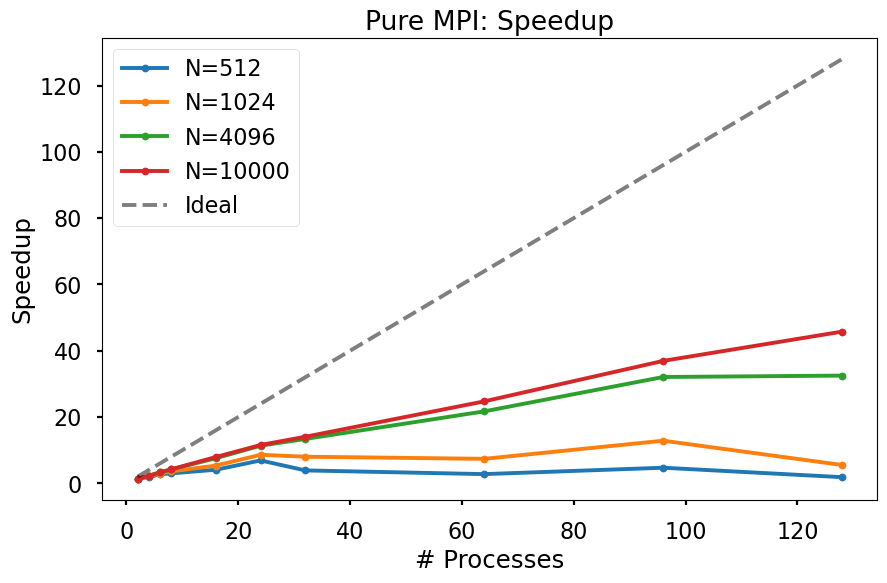

In [344]:
# Speedup
fig_base_speedup, ax_base_speedup = generic_performance_plot(base_speedup_presentation, True, ".-")
ax_base_speedup.legend()
ax_base_speedup.set_title("Pure MPI: Speedup")
ax_base_speedup.set_xlabel("# Processes")
ax_base_speedup.set_ylabel("Speedup")

fig_base_speedup.savefig("../figures/pure_mpi_speedup.png", bbox_inches="tight")

[  2   4   6   8  16  24  32  64  96 128]


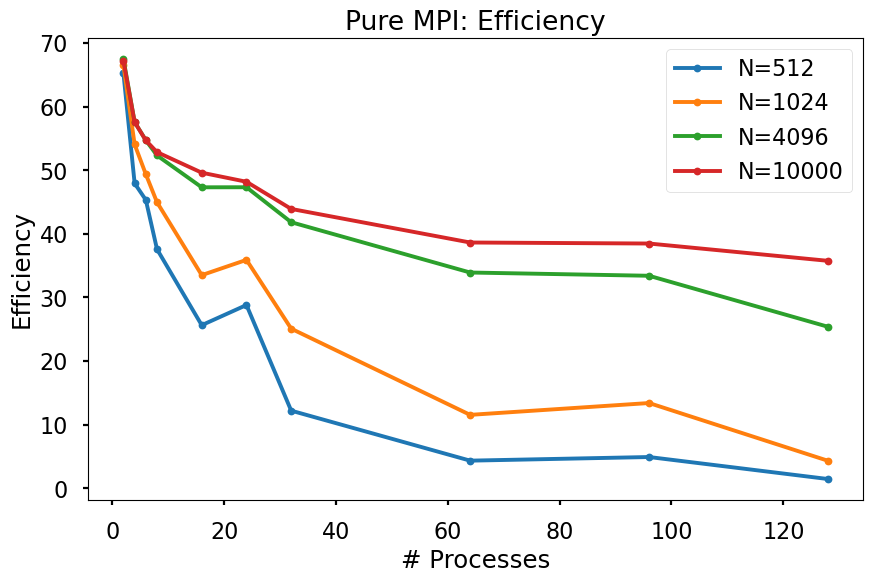

In [345]:
# Efficiencies
fig_base_efficiency, ax_base_efficiency = generic_performance_plot(base_efficiency_presentation, False, ".-")
ax_base_efficiency.legend()
ax_base_efficiency.set_title("Pure MPI: Efficiency")
ax_base_efficiency.set_xlabel("# Processes")
ax_base_efficiency.set_ylabel("Efficiency")

fig_base_efficiency.savefig("../figures/pure_mpi_efficiency.png", bbox_inches="tight")

[  1   2   4   6   8  16  24  32  64  96 128]


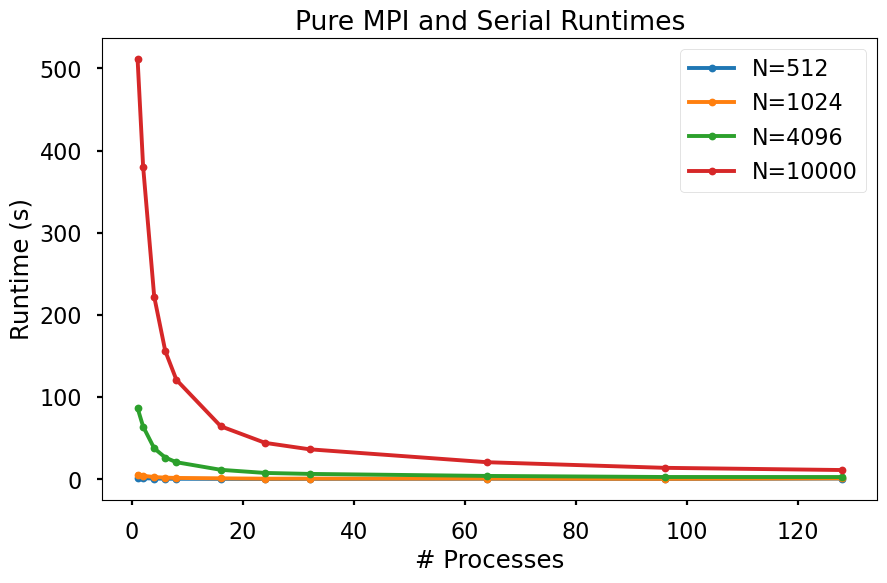

In [346]:
# Run times
# TODO: Log scale this
fig_base_rtime, ax_base_rtime = generic_performance_plot(base_rtime_presentation, False, ".-")
ax_base_rtime.legend()
ax_base_rtime.set_title("Pure MPI and Serial Runtimes")
ax_base_rtime.set_xlabel("# Processes")
ax_base_rtime.set_ylabel("Runtime (s)")

fig_base_rtime.savefig("../figures/pure_mpi_runtime.png", bbox_inches="tight")

# MPI + OpenMP Figures

[  2   4   6   8  16  24  32  64  96 128]


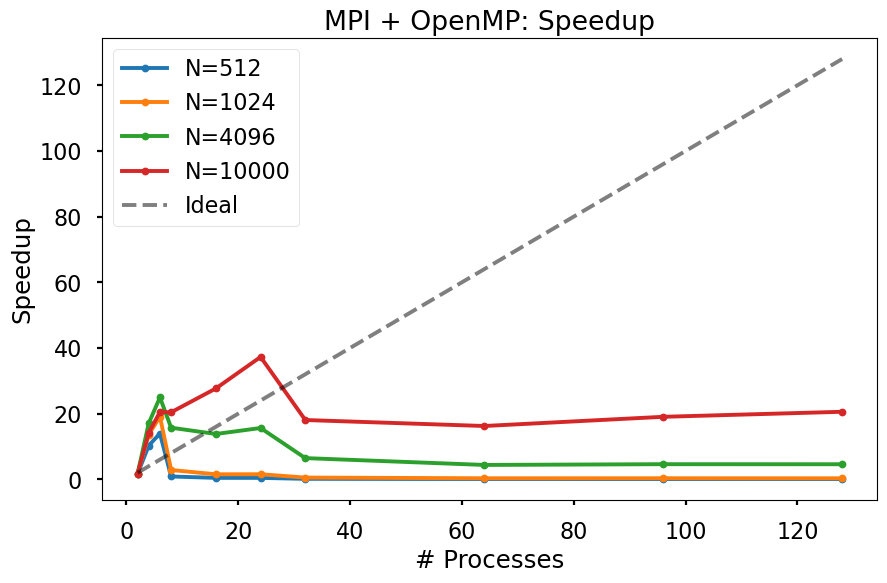

In [347]:
# Speedup
fig_opt_speedup, ax_opt_speedup = generic_performance_plot(opt_speedup_presentation, True, ".-")
ax_opt_speedup.legend()
ax_opt_speedup.set_title("MPI + OpenMP: Speedup")
ax_opt_speedup.set_xlabel("# Processes")
ax_opt_speedup.set_ylabel("Speedup")

fig_opt_speedup.savefig("../figures/hybrid_mpi_speedup.png", bbox_inches="tight")

[  2   4   6   8  16  24  32  64  96 128]


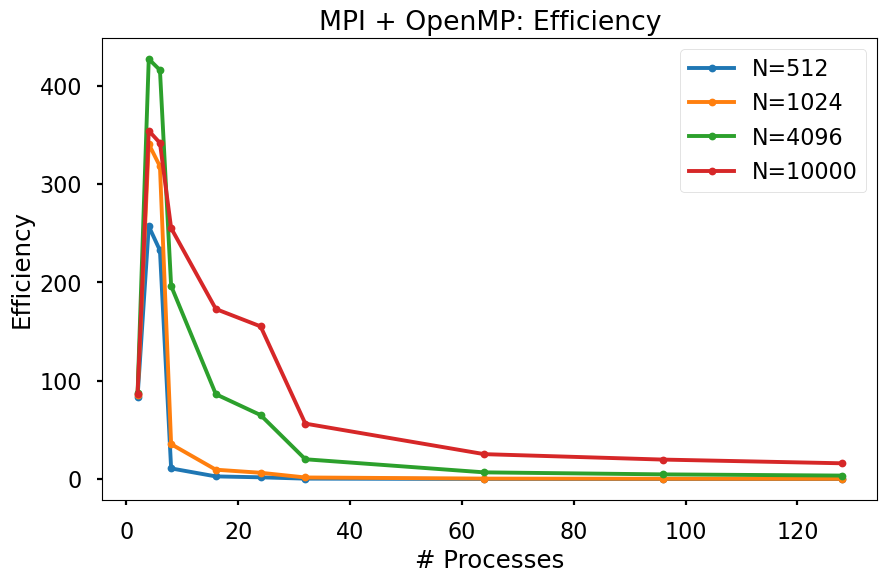

In [348]:
# Efficiencies
fig_opt_efficiency, ax_opt_efficiency = generic_performance_plot(opt_efficiency_presentation, False, ".-")
ax_opt_efficiency.legend()
ax_opt_efficiency.set_title("MPI + OpenMP: Efficiency")
ax_opt_efficiency.set_xlabel("# Processes")
ax_opt_efficiency.set_ylabel("Efficiency")

fig_opt_efficiency.savefig("../figures/hybrid_mpi_efficiency.png", bbox_inches="tight")

[  1   2   4   6   8  16  24  32  64  96 128]


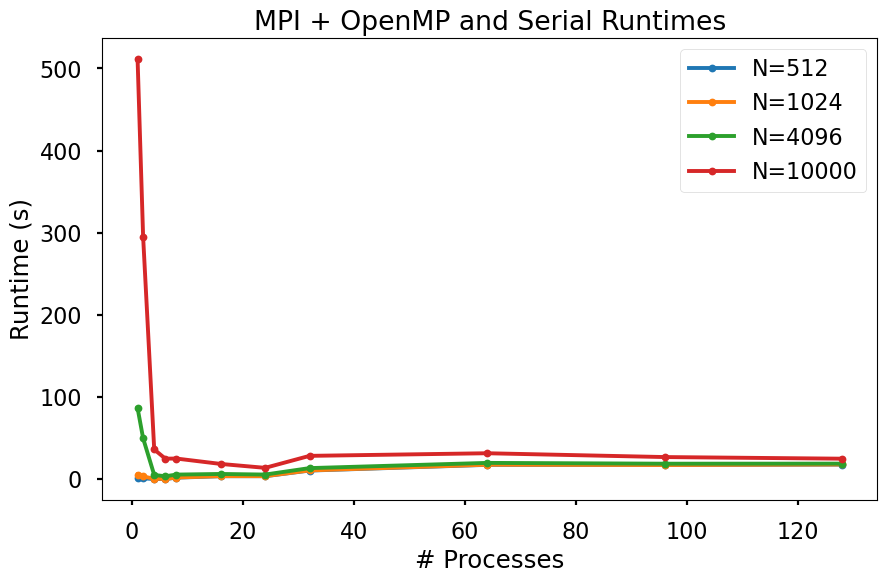

In [349]:
# Run times
# TODO: Log scale this
fig_opt_rtime, ax_opt_rtime = generic_performance_plot(opt_rtime_presentation, False, ".-")
ax_opt_rtime.legend()
ax_opt_rtime.set_title("MPI + OpenMP and Serial Runtimes")
ax_opt_rtime.set_xlabel("# Processes")
ax_opt_rtime.set_ylabel("Runtime (s)")

fig_opt_rtime.savefig("../figures/hybrid_mpi_runtime.png", bbox_inches="tight")